In [1]:
import os

import pickle

import numpy as np

import pandas as pd

from tqdm.notebook import tqdm

from PIL import Image

import requests

from io import BytesIO

import matplotlib.pyplot as plt

import tensorflow

from tensorflow import keras

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, load_model

from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Flatten


from transformers import BertTokenizer, BertModel

import json

In [2]:
print(tensorflow.__version__)

2.16.1


In [3]:
BASE_DIR = '/kaggle/input/dataset'

WORKING_DIR = '/kaggle/working/'

In [4]:
!pip install ultralytics -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
from ultralytics.nn.tasks import DetectionModel

from ultralytics.nn.tasks import attempt_load_one_weight

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
import tensorflow as tf

import torch

from tensorflow.keras.preprocessing.image import load_img, img_to_array



image = load_img("/kaggle/input/people/z5954204166284_efdac6ee53fc23f3dd6fed41f218096f.jpg", target_size=(640, 640))

image_array = img_to_array(image)

image_array = image_array.reshape((1, image_array.shape[2], image_array.shape[0], image_array.shape[1]))

print(image_array.shape)

image_tensor = torch.from_numpy(image_array)

print(image_array.shape)

(1, 3, 640, 640)
(1, 3, 640, 640)


In [7]:
import torch

import cv2

from torchvision import transforms

from ultralytics import YOLO



# Hàm tiền xử lý ảnh thành tensor cho YOLO

def preprocess_image(image):

    preprocess = transforms.Compose([

        transforms.ToPILImage(),  # Chuyển từ numpy sang PIL

        transforms.Resize((640, 640)),  # Thay đổi kích thước ảnh về 640x640

        transforms.ToTensor(),  # Chuyển thành tensor

        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa theo chuẩn của ImageNet

    ])

    tensor_image = preprocess(image).unsqueeze(0)  # Thêm batch dimension

    return tensor_image

In [8]:
import torch

from ultralytics import YOLO



# Load the YOLOv8 model

model = YOLO('yolov8n.pt')



# Access the backbone layers

backbone = model.model.model[:10]  # Layers 0 to 9 form the backbone



# Create a new Sequential model with just the backbone layers

backbone_model = torch.nn.Sequential(*backbone)

100%|██████████| 6.25M/6.25M [00:00<00:00, 105MB/s]


In [9]:
# If you want to use the backbone for feature extraction

def extract_features(image):

    with torch.no_grad():

        features = backbone_model(image)

    return features

In [10]:
import pandas as pd 
df = pd.read_csv('/kaggle/input/crawl-data-api-10k-rows/data/captions.csv')
df

,image_id,caption
0,000000000009.jpg,a variety of food items organized in colorful ...
1,000000000025.jpg,two giraffes one standing upright and reaching...
2,000000000030.jpg,a vase with a classical design featuring a flu...
3,000000000034.jpg,a zebra in a grassy field or meadow grazing or...
4,000000000036.jpg,a woman wearing a floral swimsuit standing in ...
...,...,...
9995,000000060576.jpg,an airplane with canadian north branding on it...
9996,000000060593.jpg,two men seated at a restaurant table with one ...
9997,000000060596.jpg,a man lying on a bed with three pillows holdin...
9998,000000060599.jpg,a rural setting with a cow and a horse near a ...


In [11]:
 # load features from pickle

with open(os.path.join('/kaggle/input/yolov8-lstm-imagecaption-encode-10000k/10k_image_features.pkl'), 'rb') as f:

  features = pickle.load(f)

In [12]:
features['000000000009.jpg'].size()

torch.Size([1, 256, 20, 20])

In [13]:
captions_doc = ""

for caption in df['caption']:

    captions_doc += caption + "\n"  # Thêm dấu xuống dòng giữa các caption nếu cần

In [14]:
def clean(mapping, start_end_token = True):

        for key, captions in mapping.items():

            for i in range(len(captions)):

                # take one caption at a time

                caption = captions[i]

                # preprocessing steps

                # convert to lowercase

                caption = caption.lower()

                # delete digits, special  chars, etc, ..

                caption = caption.replace('[^A-Za-z]', '')

                # delete additional spaces

                caption = caption.replace('\s+', ' ')

                if start_end_token == True:

                    # add start and end tags to the caption

                    caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'

                captions[i] = caption

        return mapping

In [15]:
# create mapping of image to captions

mapping = {}

# process lines

for index, row in tqdm(df.iterrows(), total=df.shape[0]):

  image_id = row['image_id']

  caption = row['caption']

  # remove extension from image ID

  image_id = image_id.split('.')[0]

  # create list if needed

  if image_id not in mapping:

    mapping[image_id] = []

  # store the caption

  mapping[image_id].append(caption)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
clean(mapping)

{'000000000009': ['startseq variety of food items organized in colorful containers the main objects in the image include bread broccoli oranges pineapples almonds cookies butter meatballs and possibly few others there are six colorful containers in the image each containing different food items fruits in the picture include oranges and pineapples there are multiple pieces of bread and the broccoli is placed in yellow container the meatball is located below the broccoli in the same yellow container the cookies are round with textured surface possibly indicating chocolate chip cookies there is butter in one of the containers the meal appears to be lunch or dinner meal combining main items like bread and meatballs with side items such as fruits vegetables and treat cookie the use of separate containers suggests it might be packed or onthego meal possibly bentostyle lunch box endseq'],
 '000000000025': ['startseq two giraffes one standing upright and reaching for the branches of tree while

In [17]:
# after preprocess of text
mapping['000000000036']

['startseq woman wearing floral swimsuit standing in front of signboard with an unreadable text holding pink umbrella in her hand and wearing headband she is standing in front of body of water with few distant swimmers or objects visible the mood of the image is joyful and carefree with blue sky and summery atmosphere endseq']

In [18]:
all_captions = []

for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [19]:
# tokenize the text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_caption = tokenizer(all_captions, return_tensors='pt', padding=True, truncation=True)
vocab_size = tokenizer.vocab_size

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
vocab_size

30522

In [21]:
# get maximum length of the caption available

max_length = max(len(caption.split()) for caption in all_captions)

max_length

299

# Split - train - test - val 

In [22]:
SAVE_CHECKPOINT_DIR = WORKING_DIR

In [23]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

import numpy as np

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()

    n = 0

    while True:

        for key in data_keys:

            n += 1

            caption = mapping[key]  # lấy caption trực tiếp từ mapping với key


            # Encode the sequence using BertTokenizer

            encoded = tokenizer(caption, return_tensors='pt', padding=True, truncation=True, max_length=max_length) # Ensure padding and truncation are done correctly

            seq = encoded['input_ids'][0]  # Lấy input_ids từ tokenizer

            # Convert input_ids và attention_mask thành numpy arrays

            seq = np.array(seq)

            
            # split the sequence into X, y pairs

            for i in range(1, len(seq)):

                # split into input and output pairs

                in_seq, out_seq = seq[:i], seq[i]

                # pad input sequence

                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post') [0] # Pad sequences at the end

                # encode output sequence

                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store the sequences

                # feature_key = 'http://images.cocodataset.' + key + '.jpg'
                feature_key = key + '.jpg'

                X1.append(features[feature_key][0])

                X2.append(in_seq)

                y.append(out_seq)


            if n == batch_size:

                X1, X2, y = np.array(X1), np.array(X2), np.array(y)

                yield (X1, X2), y

                X1, X2, y = list(), list(), list()

                n = 0

In [24]:
SAVE_CHECKPOINT_DIR = WORKING_DIR

In [25]:
# Split data into train, validation and test sets
image_ids = list(mapping.keys())
train_split = int(len(image_ids) * 0.80)
val_split = int(len(image_ids) * 0.10)

train = image_ids[:train_split]
val = image_ids[train_split:train_split+val_split]
test = image_ids[train_split+val_split:]

In [26]:
# Save model configuration
model_config = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'embedding_dim': 256,
    'dropout_rate': 0.4,
    'lstm_units': 256
}

with open(os.path.join(WORKING_DIR, 'model_config.json'), 'w') as f:
    json.dump(model_config, f)

In [27]:
def create_model(config):
    # Image feature extraction
    inputs1 = Input(shape=(256, 20, 20))
    fe1 = Flatten()(inputs1)
    fe1 = Dropout(config['dropout_rate'])(fe1)
    fe2 = Dense(256, activation='relu', 
                kernel_regularizer=tf.keras.regularizers.l2(0.01))(fe1)
    
    # Sequence processing
    inputs2 = Input(shape=(config['max_length'],))
    se1 = Embedding(config['vocab_size'], config['embedding_dim'], mask_zero=True)(inputs2)
    se2 = Dropout(config['dropout_rate'])(se1)
    se3 = LSTM(config['lstm_units'], return_sequences=False, 
               recurrent_regularizer=tf.keras.regularizers.l2(0.01))(se2)
    
    # Decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(config['vocab_size'], activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.00015),
                 metrics=['accuracy'])
    return model

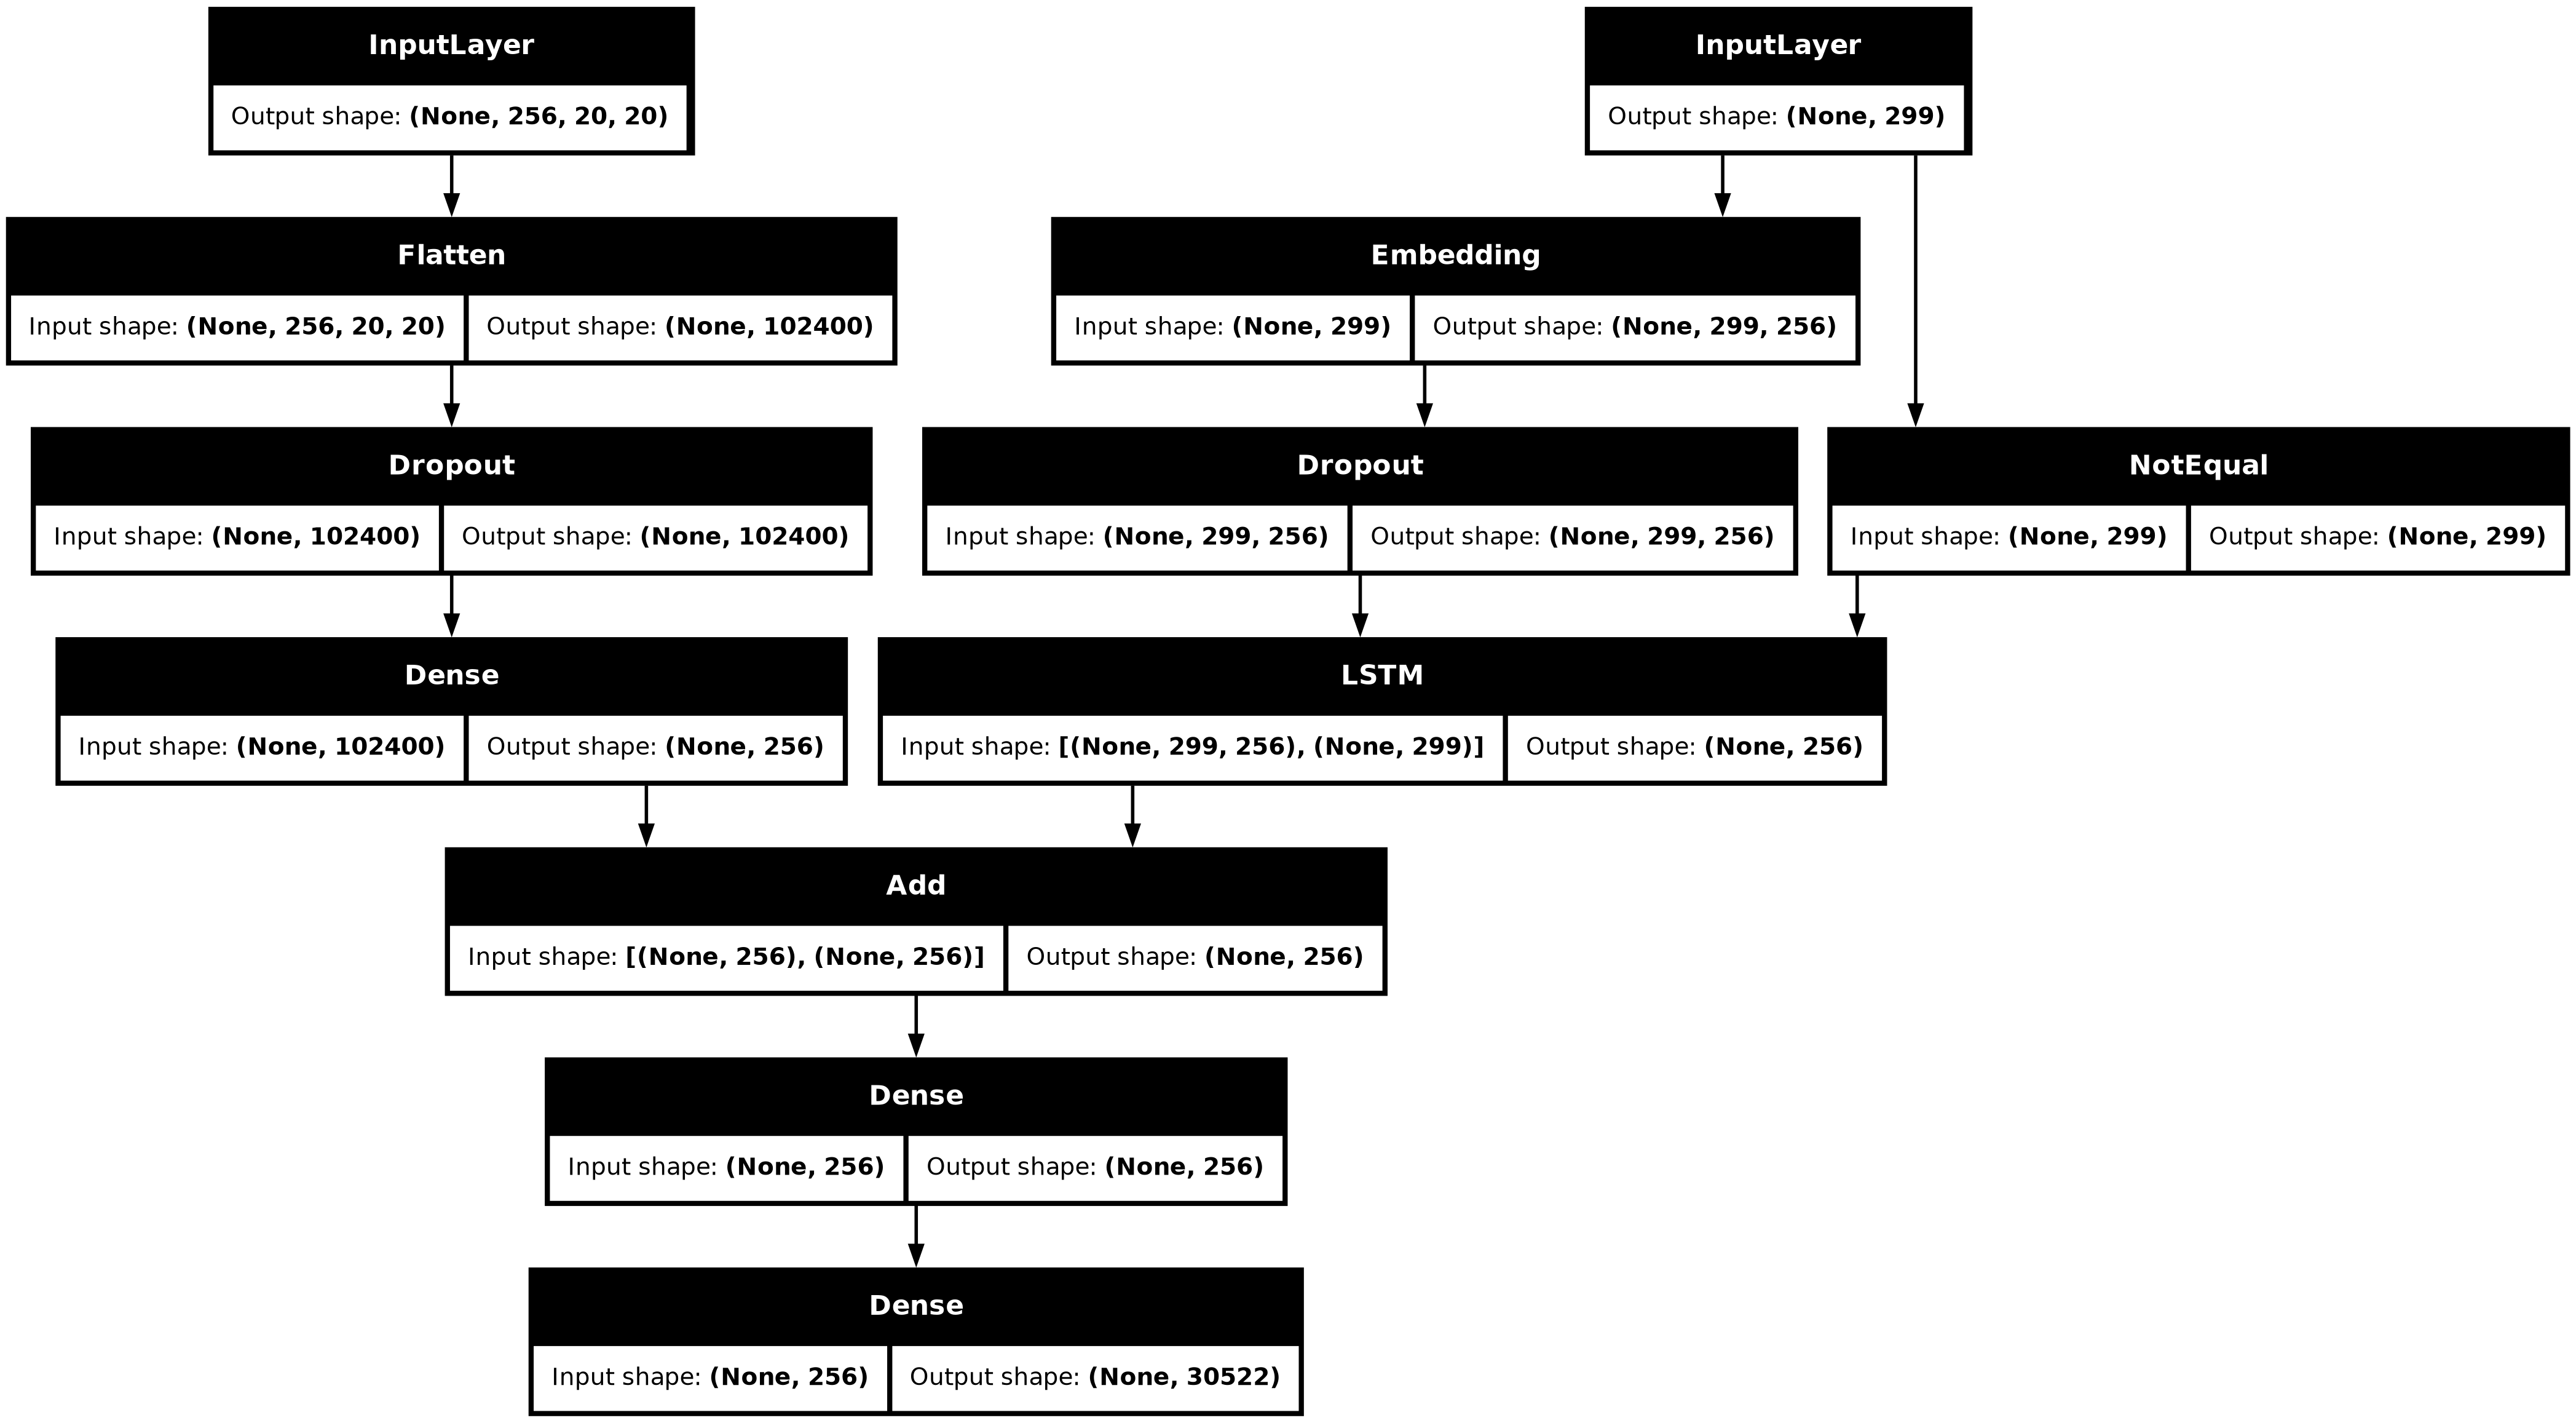

In [28]:
model = create_model(model_config)

# plot the model
plot_model(model, show_shapes=True)

In [29]:
# Training callbacks
checkpoint_path = os.path.join(SAVE_CHECKPOINT_DIR, "yolo_bert_lstm_cp-{epoch:04d}.weights.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

In [30]:
class TrainingHistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {}
    
    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            self.history.setdefault(metric, []).append(logs[metric])
        with open(os.path.join(WORKING_DIR, 'training_history.json'), 'w') as f:
            json.dump(self.history, f)

history_callback = TrainingHistoryCallback()

In [31]:
# Training Part 1
# model = create_model(model_config)
# epochs_part1 = 10
# batch_size = 8
# steps = len(train) // batch_size
# val_steps = len(val) // batch_size

In [32]:
# train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# history1 = model.fit(
#     train_generator,
#     epochs=epochs_part1,
#     steps_per_epoch=steps,
#     validation_data=val_generator,
#     validation_steps=val_steps,
#     callbacks=[checkpoint_callback, early_stopping, reduce_lr, history_callback],
#     verbose=1
# )

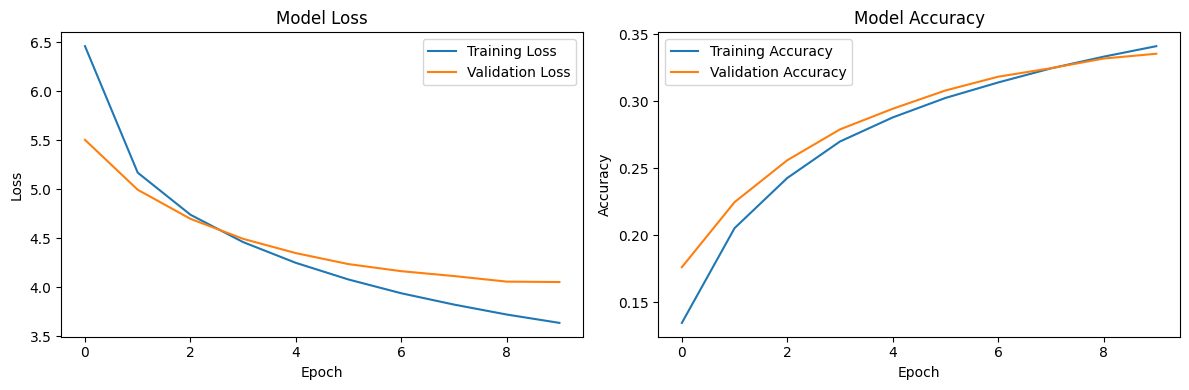

In [33]:
def plot_training_history(history_file):
    with open(history_file, 'r') as f:
        history = json.load(f)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(os.path.join('/kaggle/input/yolov8-bert-lstm-train-test-val-0-00015/training_history.json'))

# Continue Training 

In [34]:
# 1. Load model configuration
with open(os.path.join('/kaggle/input/yolov8-bert-lstm-train-test-val-0-00015/model_config.json'), 'r') as f:
    model_config = json.load(f)

# 2. Khởi tạo model mới với cấu trúc cũ
model = create_model(model_config)

# 3. Load weights từ checkpoint cuối cùng
latest_checkpoint = tf.train.latest_checkpoint(SAVE_CHECKPOINT_DIR)
if latest_checkpoint:
    print(f"Loading weights from: {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
else:
    print("No checkpoint found. Starting from scratch.")

# 4. Load training history cũ (nếu có)
history_file = os.path.join('/kaggle/input/yolov8-bert-lstm-train-test-val-0-00015/training_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        previous_history = json.load(f)
    initial_epoch = len(previous_history['loss'])  # Số epoch đã train
else:
    initial_epoch = 0

# 5. Tiếp tục training
epochs = 10  # Tổng số epoch muốn train
batch_size = 8
steps = len(train) // batch_size
val_steps = len(val) // batch_size

# Điều chỉnh learning rate
model.optimizer.learning_rate = 0.00015  # Giảm learning rate để fine-tune

# Continue training
history = model.fit(
    data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    epochs=epochs,
    initial_epoch=initial_epoch,  # Bắt đầu từ epoch cuối cùng
    steps_per_epoch=steps,
    validation_data=data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    validation_steps=val_steps,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(SAVE_CHECKPOINT_DIR, "yolo_bert_lstm_cp-{epoch:04d}.weights.h5"),
            save_weights_only=True,
            save_best_only=True,
            monitor='val_loss',
            mode='min'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.00001
        ),
        TrainingHistoryCallback()
    ],
    verbose=1
)


No checkpoint found. Starting from scratch.


125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 663ms/step - accuracy: 0.0000e+00 - loss: 17.9954
Updated Test Loss: 17.9954
Updated Test Accuracy: 0.0000


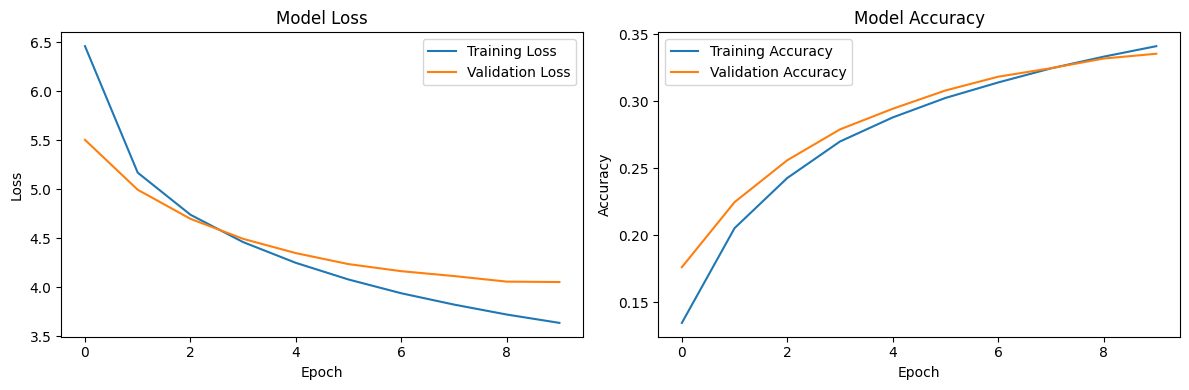

In [35]:

# 6. Evaluate sau khi train thêm
test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
test_steps = len(test) // batch_size
evaluation = model.evaluate(test_generator, steps=test_steps)
print(f"Updated Test Loss: {evaluation[0]:.4f}")
print(f"Updated Test Accuracy: {evaluation[1]:.4f}")

# 7. Visualize training history
plot_training_history(history_file)

## Load model 

In [36]:
# model_path = '/kaggle/input/yolov8-bert-lstm-train-test-val-20epocs/keras/default/1/yolo_bert_lstm_cp-0012.weights.h5'

# # Tạo lại mô hình giống như ban đầu

# model = create_model(model_config)

# # Tải trọng số từ tệp checkpoint

# model.load_weights(model_path)